In [1]:
import torch
from transformers import AutoProcessor, Pix2StructProcessor
import numpy as np
from einops import rearrange
import torchvision.transforms.functional as TF
from arg_utils import Args

import os
from utils import build_model
from PIL import Image
from utils import find_bg, post_process_mask

/home/msouibgui/anaconda3/envs/mp_docvqa/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load model

In [ ]:
# os.environ["CUDA_VISIBLE_DEVICES"]="1" # uncomment and set the visible CUDA device to the desired GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model_path = "./weights/docvxqa_sp.pth" # Path to the model weights that you downloaded

args = Args().parse_args(known_only=True)
model, processor = build_model(args.model, task="vqa", args=args)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()

print(f"Model loaded from {model_path}")

Using device: cuda


/tmp/ipykernel_3815321/1202909120.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model loaded from ./weights/docvxqa_sp.pth


## Prepare the query: image and question

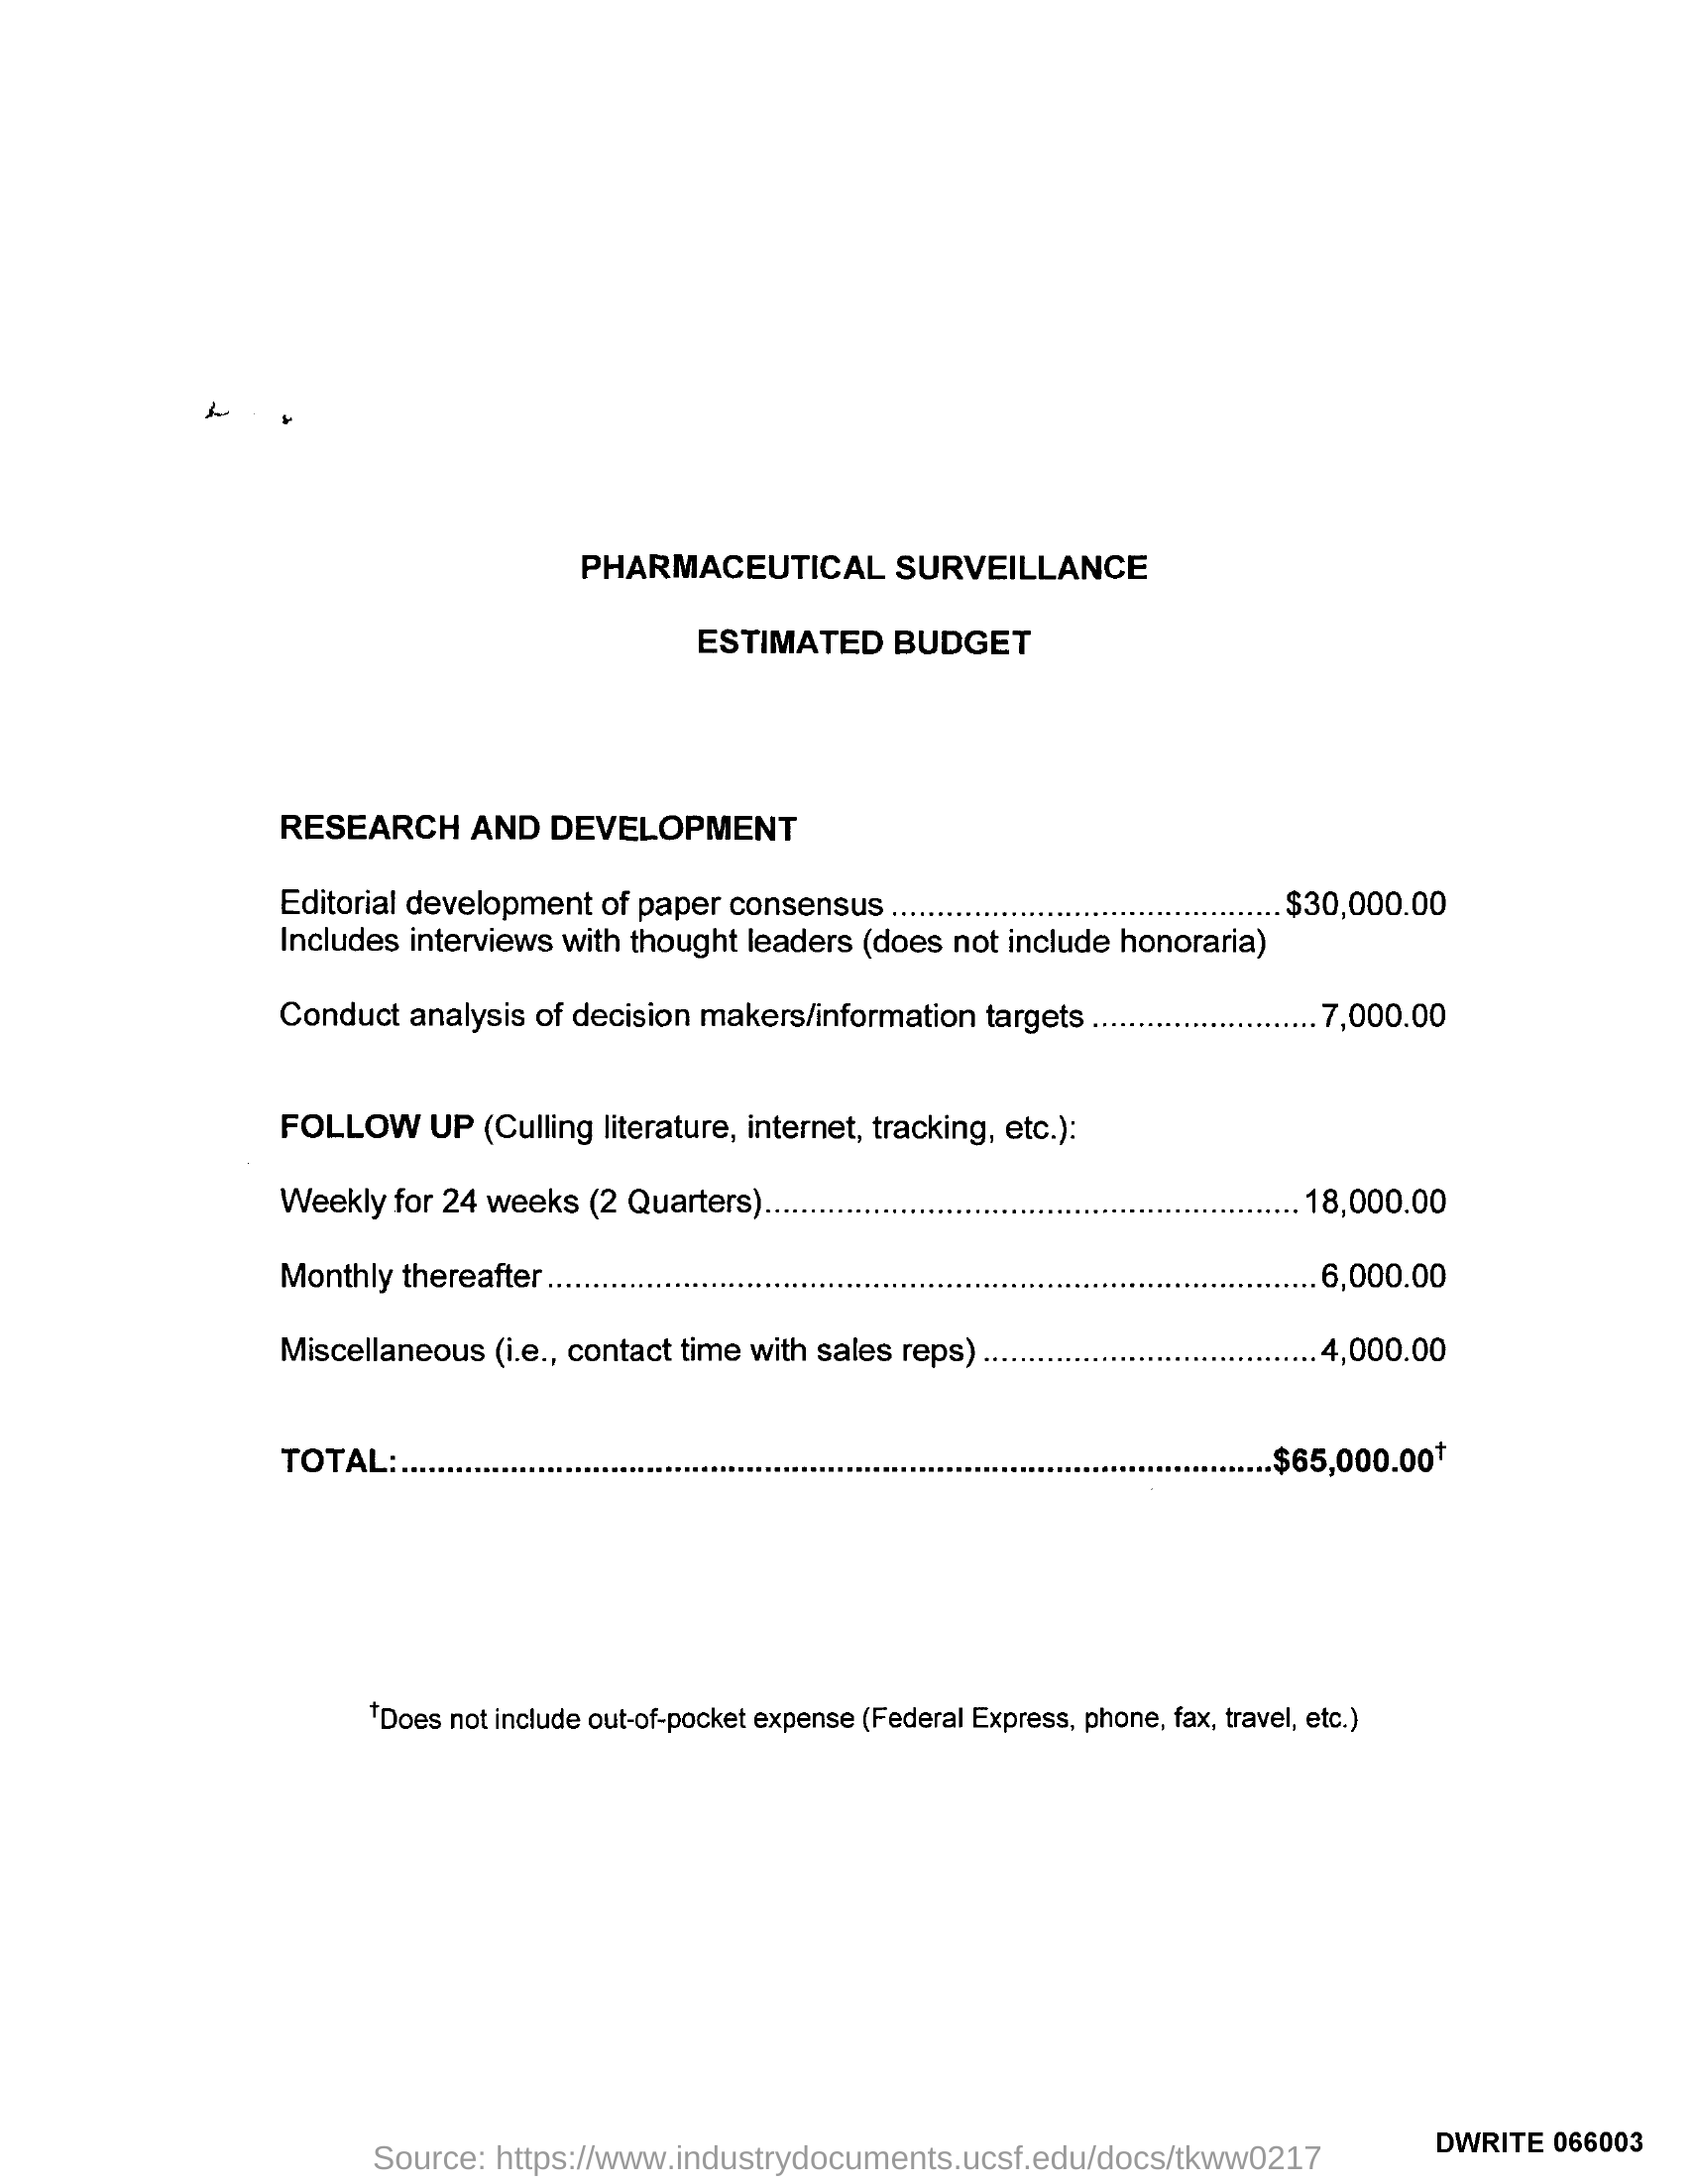

In [3]:
img_path = "imgs/demo/image_2.png" # Change this to the path of your image
image = Image.open(img_path).convert("RGB")
image 

In [4]:
# set here the question to be asked
question = "What is the estimated budget of ‘conduct analysis of decision makers/ information targets’ in research and development?"

## Encode the query

In [5]:
processor = AutoProcessor.from_pretrained("ybelkada/pix2struct-base")
processor_renderer = Pix2StructProcessor.from_pretrained("google/pix2struct-docvqa-base")
encodings = processor_renderer(images=image, text=question, return_tensors="pt", add_special_tokens=True, max_patches=2048, padding=True)
encodings = encodings.to(device)
flattened_patches, attention_mask = encodings["flattened_patches"], encodings["attention_mask"]

## Predict the answer on the plain image

We first show how the model render the question on top of the image.

torch.Size([3, 832, 608])


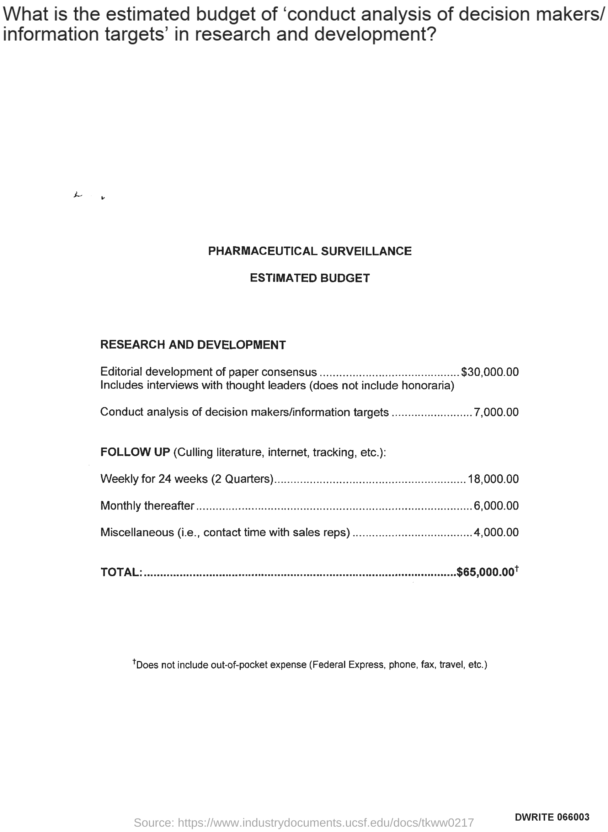

In [6]:
p1 = int(max(list(flattened_patches[:,:,0].cpu().numpy())[0]))
p2 = int(max(list(flattened_patches[:,:,1].cpu().numpy())[0]))

patches = p1*p2


img = np.array(image)/ 255.0
mean = np.mean(img, axis=(0, 1))[0]
std = np.std(img, axis=(0, 1))[0]

mean = [mean, mean, mean]
std = [std, std, std]

t_img_m = rearrange(flattened_patches[:,:patches,2:], 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
                                p1 = 16, p2 = 16,  h=p1).cpu()
t_img_m = t_img_m * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)


t_img_m = t_img_m.squeeze(0)
print(t_img_m.shape)
pil_image = TF.to_pil_image(t_img_m)
pil_image

Then, use the model to predict the answer:

In [7]:
prediction_docvqa = model.pix2struct_model.generate(flattened_patches=flattened_patches.to(device), attention_mask=attention_mask.to(device),  max_length= 100)
prediction_docvqa = processor.decode(prediction_docvqa[0], skip_special_tokens=True)

print(f"Question: {question}")
print(f"Plain Image Prediction: {prediction_docvqa}")

Question: What is the estimated budget of ‘conduct analysis of decision makers/ information targets’ in research and development?
Plain Image Prediction: 7,000.00


## Predict the mask

In [8]:
quan_thresh = 0.7 # Set the quantile threshold for mask generation

text_inputs = processor(text=[prediction_docvqa], padding="max_length", truncation=True, return_tensors="pt", add_special_tokens=True, max_length=args.max_length)
labels = text_inputs.input_ids
labels = labels.to(device)

encoder_output = model.pix2struct_model.encoder(flattened_patches, output_hidden_states=True)
features = encoder_output['last_hidden_state']
decoder_input_ids = model.pix2struct_model._shift_right(labels)
decoder_attention_mask = decoder_input_ids.ne(model.pix2struct_model.config.pad_token_id).float()
decoder_attention_mask[:, 0] = 1
pos_encoding = flattened_patches[:,:,:2]


decoder_output = model.pix2struct_model.decoder(
    input_ids=decoder_input_ids,
    attention_m884ask=decoder_attention_mask,
    encoder_attention_mask=attention_mask,
    labels=labels,
    encoder_hidden_states = encoder_output[0],
    output_hidden_states=True,
    output_attentions=True
)

cross_attention_11 = decoder_output["cross_attentions"][11]
sequence_logits = decoder_output['logits']
sequence_classes = torch.argmax(sequence_logits, 2)
lenghts = [len(sq[sq!= 0])-1 for sq in sequence_classes]
all_heads_attn_11 = torch.stack([torch.sum(torch.sum(cross_attention_11[k,:,:i,:args.max_patches], 1), 0).unsqueeze(-1) for k, i in enumerate(lenghts)])
all_heads_attn_11 = all_heads_attn_11.repeat(1, 1, 768)
feat_attn = torch.cat((pos_encoding, features, all_heads_attn_11), 2)
mask_out_raw = model.mask_head_deocder(feat_attn)
mask_out = (mask_out_raw > torch.quantile(mask_out_raw, quan_thresh).item()).float()

width, height = image.size
aspect_ratio = height / width
new_width = pil_image.size[0]
new_height = int(new_width * aspect_ratio)

header_ratio = (pil_image.size[1] - new_height) / image.size[1]


num_tokens = flattened_patches.size(1)
batch_header_rows = torch.ceil(pos_encoding[:,:,0].max(1)[0] * header_ratio).int()
batch_header_tokens = batch_header_rows * pos_encoding[:,:,1].max(1)[0] 
batch_tokens = torch.arange(num_tokens, device=flattened_patches.device)

mask_2 = batch_tokens.unsqueeze(0) < batch_header_tokens.unsqueeze(1)
mask_out[mask_2] = 1.0


## Post process the predicted mask

In [9]:
# remove background relevant patches
mask_out = find_bg(flattened_patches, mask_out)
mask_out[mask_2] = 1.0

# post-process to draw bounding boxes and keep only top ones
width, height = image.size
aspect_ratio = height / width
new_width = pil_image.size[0]
new_height = int(new_width * aspect_ratio)
header_ratio = (pil_image.size[1] - new_height) / new_height
num_tokens = flattened_patches.size(1)
batch_header_rows = torch.ceil(pos_encoding[:,:,0].max(1)[0] * header_ratio).int()
batch_header_tokens = batch_header_rows * pos_encoding[:,:,1].max(1)[0] 
batch_tokens = torch.arange(num_tokens, device=flattened_patches.device)
image_header = batch_tokens.unsqueeze(0) < batch_header_tokens.unsqueeze(1)

cross_attention_11 = decoder_output["cross_attentions"][11]
attn_11 = torch.sum(cross_attention_11[:,:,0,:args.max_patches], 1)
att_imgs = [flattened_patches[i,:[patches][i],2:].clone() for i in range(len([patches]))]
for i in range(len([patches])):
    for j in range([patches][i]):
        att_imgs[i][j,:] = attn_11[i, j]
    att_imgs[i] = rearrange(att_imgs[i].unsqueeze(0), 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
                                p1 = 16, p2 = 16,  h=[p1][i]).cpu().squeeze(0)

processed_mask_out = post_process_mask(mask_out, att_imgs, [p1], [p2], k=2, img_header=image_header)

## Predict teh answer using only the explainability relevant regions (masked image)
Predict the answer:

In [10]:
flattened_patches_masked = processed_mask_out * flattened_patches
prediction_masked_docvqa = model.pix2struct_model.generate(flattened_patches=flattened_patches_masked, attention_mask=attention_mask,  max_length= 100)
prediction_masked_docvqa = processor.decode(prediction_masked_docvqa[0], skip_special_tokens=True)

print(f"Question: {question}")
print(f"Prediction Masked DocVQA: {prediction_masked_docvqa}")


Question: What is the estimated budget of ‘conduct analysis of decision makers/ information targets’ in research and development?
Prediction Masked DocVQA: 7,000,000.00


Show the predicted mask (explainability relevance regions)

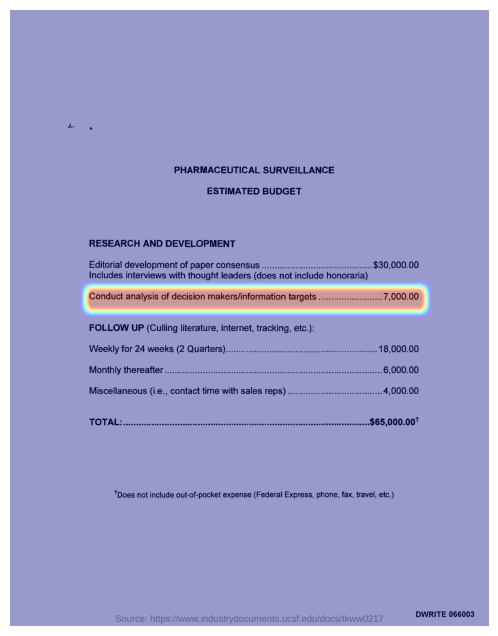

In [11]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

mask_out[image_header] = 0.
mask_out_img = rearrange(mask_out[:,:patches,:], 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
                                 p1 = 1, p2 = 1,  h=p1).cpu()
mask_out_img = mask_out_img.squeeze()
# remove 
removed_ratio = header_ratio
mask_out_img = mask_out_img[int(mask_out_img.size(0)*removed_ratio):, :]
mask_out_img = TF.to_pil_image((mask_out_img).float())



target_size  = image.size
# resize mask_out_img to target_size
mask_out_img = mask_out_img.resize(target_size)


img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)

heatmap = cv2.cvtColor(np.array(mask_out_img), cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = heatmap / 255.0

heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(superimposed_img, cmap='viridis')
plt.show()
# name the output image 